In [ ]:
%load_ext autoreload
%autoreload 2

from main import *

import matplotlib.pyplot as plt

def solve_numerically(selected_solver: str):
# Set the numerical solver stated in the selected_solver argument
    match selected_solver:
        case "Explicit Euler":
            func = explicit_euler.solve
        case "Symplectic Euler":
            func = symplectic_euler.solve
        case _:
            raise ValueError(f"{selected_solver} is not a known solver.")

    # Solve PDE for initial state Y0 and time span t_span
    return func(double_pendulum.vector_field, "_", Y0, T_SPAN)

def plot_phase_space(y_exp, y_sym):
    """
    Plot a projected phase-space trajectory for the double pendulum,
    e.g. (theta1, p_theta1). Adapt if you wish to project differently.
    """
    plt.figure(figsize=(6,4))
    plt.plot(y_exp[:, 0], y_exp[:, 1], label='Explicit Euler', alpha=0.8)
    plt.plot(y_sym[:, 0], y_sym[:, 1], label='Symplectic Euler', alpha=0.8)
    plt.title("Double Pendulum Phase Space (Projected)")
    plt.xlabel(r"$\theta_1$")
    plt.ylabel(r"$p_{\theta_1}$")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


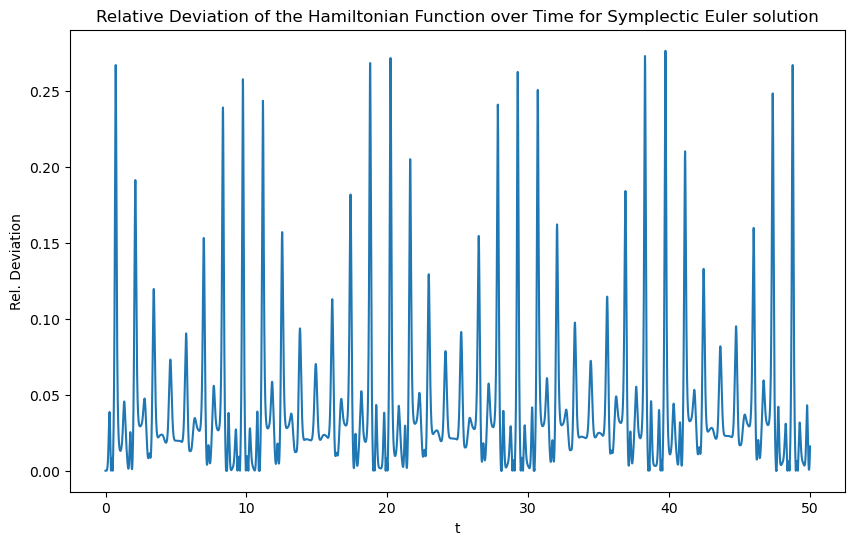

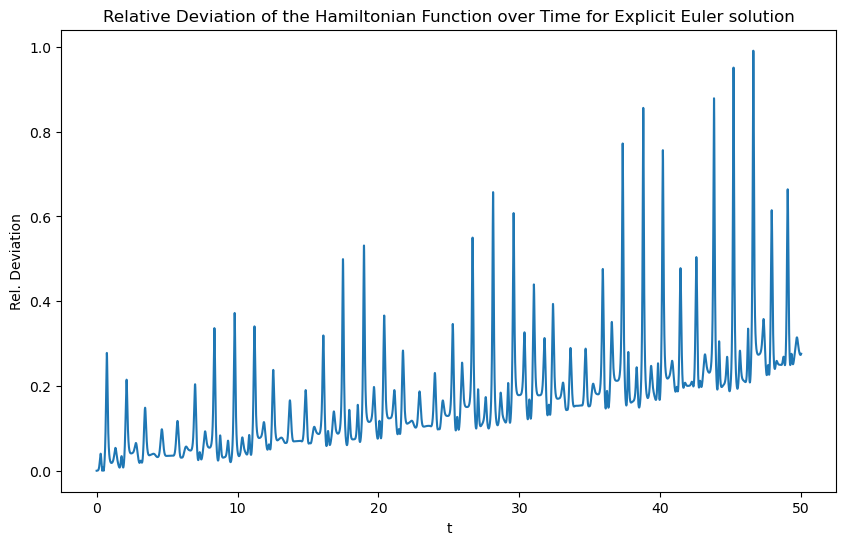

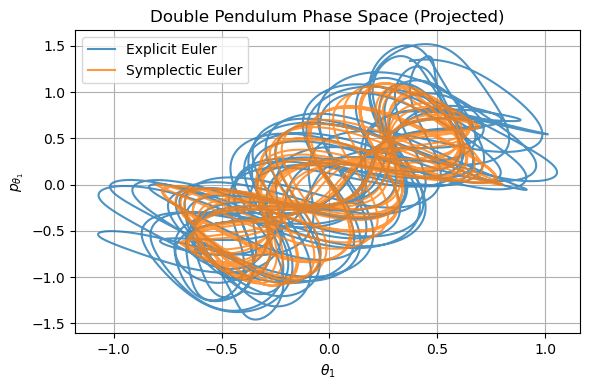

In [ ]:
selected_solver = "Symplectic Euler"
t_sym, y_sym = solve_numerically("Symplectic Euler")

# Plot the Hamiltonian over time to see if it stays constant
utils.plot_hamiltonian_deviation_over_time(t_sym, y_sym, selected_solver)

selected_solver = "Explicit Euler"
t_exp, y_exp = solve_numerically("Explicit Euler")
# Plot the Hamiltonian over time to see if it stays constant
utils.plot_hamiltonian_deviation_over_time(t_exp, y_exp, selected_solver)

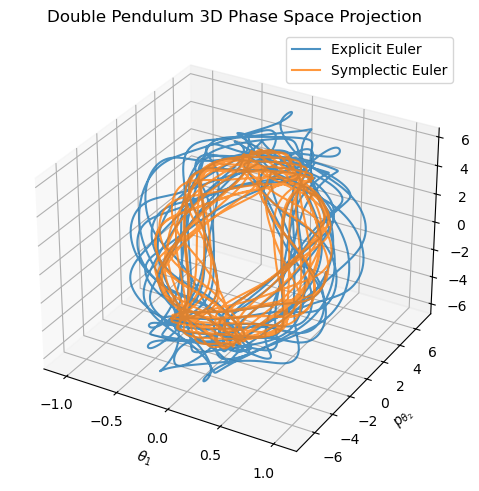

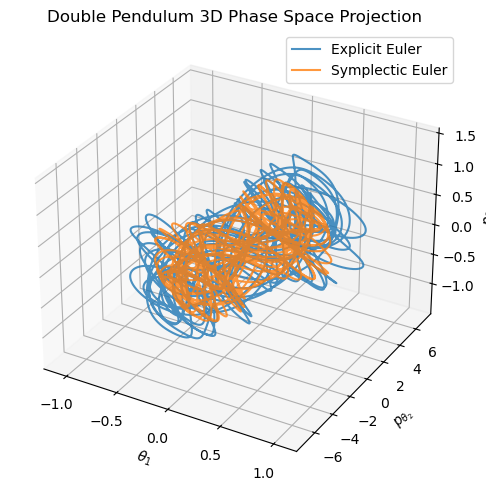

In [ ]:
def plot_phase_space_3d(y_exp, y_sym, coords=(0, 1, 2)):
    """
    Plot a 3D projection of the phase space for the double pendulum.
    
    Parameters
    ----------
    y_exp : np.ndarray
        Trajectory from the Explicit Euler solver, shape (num_steps, 4).
    y_sym : np.ndarray
        Trajectory from the Symplectic Euler solver, shape (num_steps, 4).
    coords : tuple of int
        A 3-element tuple specifying which indices (0..3) of the state
        to plot on the x, y, and z axes, respectively.
        
        State ordering typically:
            0 -> theta_1
            1 -> p_theta_1
            2 -> theta_2
            3 -> p_theta_2
    """
    # Define labels for each of the 4 state dimensions
    coord_labels = [
        r"$\theta_{1}$",
        r"$p_{\theta_{1}}$",
        r"$\theta_{2}$",
        r"$p_{\theta_{2}}$"
    ]
    
    # Extract coordinates for Explicit Euler
    x_exp = y_exp[:, coords[0]]
    y_exp_ = y_exp[:, coords[1]]   # rename so we don't overwrite y_exp array
    z_exp = y_exp[:, coords[2]]
    
    # Extract coordinates for Symplectic Euler
    x_sym = y_sym[:, coords[0]]
    y_sym_ = y_sym[:, coords[1]]
    z_sym = y_sym[:, coords[2]]
    
    # Create a 3D plot
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot each solver's trajectory in 3D
    ax.plot(x_exp, y_exp_, z_exp, label='Explicit Euler', alpha=0.8)
    ax.plot(x_sym, y_sym_, z_sym, label='Symplectic Euler', alpha=0.8)
    
    # Label axes using coord_labels
    ax.set_xlabel(coord_labels[coords[0]])
    ax.set_ylabel(coord_labels[coords[1]])
    ax.set_zlabel(coord_labels[coords[2]])
    
    ax.set_title("Double Pendulum 3D Phase Space Projection")
    ax.legend()
    plt.tight_layout()
    plt.show()

# Plot the phase space trajectory
plot_phase_space_3d(y_exp, y_sym, coords=(0, 3, 2))

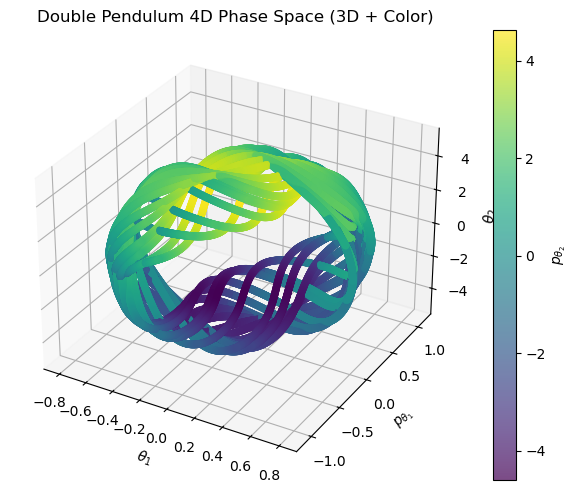

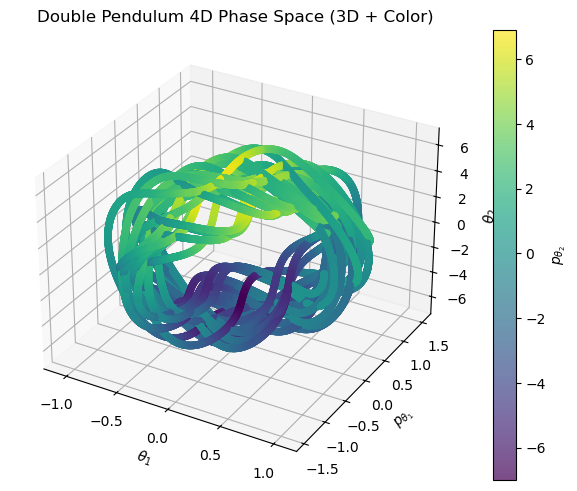

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_3d_with_color(y):
    """
    y is (N, 4). We'll plot (theta1, ptheta1, theta2) in 3D
    with ptheta2 as the color.
    """
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot(111, projection='3d')
    
    x = y[:, 0]  # theta1
    y_ = y[:, 1] # ptheta1
    z = y[:, 2]  # theta2
    c = y[:, 3]  # ptheta2 as color

    sc = ax.scatter(x, y_, z, c=c, cmap='viridis', alpha=0.7)
    plt.colorbar(sc, label=r"$p_{\theta_2}$")
    ax.set_xlabel(r"$\theta_1$")
    ax.set_ylabel(r"$p_{\theta_1}$")
    ax.set_zlabel(r"$\theta_2$")
    ax.set_title("Double Pendulum 4D Phase Space (3D + Color)")
    plt.tight_layout()
    plt.show()

# Plot the 3D phase space with p_theta_2 as the color
plot_3d_with_color(y_sym)
plot_3d_with_color(y_exp)

In [ ]:
import numpy as np

def compute_poincare_section(t_values, y_values, crossing_coord_idx=2, crossing_value=0.0,
                             crossing_direction='positive'):
    """
    Compute a Poincaré section for a 4D system with state (theta1, ptheta1, theta2, ptheta2).
    
    We detect times when the coordinate at index `crossing_coord_idx` crosses 
    `crossing_value` in the specified direction and record the other coordinates at that crossing.

    Parameters
    ----------
    t_values : np.ndarray
        Array of time points (shape: (N,)).
    y_values : np.ndarray
        Array of state values (shape: (N, 4)) for the double pendulum.
    crossing_coord_idx : int
        Which state index to use for the crossing detection. 
        Default 2 corresponds to 'theta2'.
    crossing_value : float
        The value at which we define the cross-section plane. Default 0.0 (e.g., theta2 = 0).
    crossing_direction : str
        'positive' means we detect upward (increasing) zero-crossings,
        'negative' for downward (decreasing) zero-crossings,
        or 'both' for all zero-crossings.

    Returns
    -------
    crossing_points : list of np.ndarray
        List of the states (including all 4 dims) that crossed the chosen plane.
    crossing_times : list of float
        List of times at which the crossings occurred.
    """

    crossing_points = []
    crossing_times = []

    # We find indices i where y_values[i, crossing_coord_idx] crosses crossing_value
    # We'll check sign changes between consecutive samples
    crossing_coord = y_values[:, crossing_coord_idx]

    for i in range(len(t_values) - 1):
        val_now = crossing_coord[i]
        val_next = crossing_coord[i+1]

        if crossing_direction in ['positive', 'both']:
            # upward crossing: val_now < crossing_value <= val_next
            if val_now < crossing_value and val_next >= crossing_value:
                # linear interpolation to find crossing time and states
                alpha = (crossing_value - val_now) / (val_next - val_now + 1e-12)
                t_cross = t_values[i] + alpha*(t_values[i+1] - t_values[i])
                # linear interpolation for entire state
                state_cross = y_values[i] + alpha*(y_values[i+1] - y_values[i])
                crossing_times.append(t_cross)
                crossing_points.append(state_cross)

        if crossing_direction in ['negative', 'both']:
            # downward crossing: val_now > crossing_value >= val_next
            if val_now > crossing_value and val_next <= crossing_value:
                alpha = (crossing_value - val_now) / (val_next - val_now + 1e-12)
                t_cross = t_values[i] + alpha*(t_values[i+1] - t_values[i])
                state_cross = y_values[i] + alpha*(y_values[i+1] - y_values[i])
                crossing_times.append(t_cross)
                crossing_points.append(state_cross)

    return crossing_points, crossing_times


def plot_poincare_section(crossing_points, coords=(0, 1), labels=None):
    """
    Plot the Poincaré section in 2D, using the states in `crossing_points`.
    
    coords : tuple of int
        Which two indices of the 4D state to plot. 
        Default (0, 1) means (theta1, ptheta1).
    labels : list of str
        Labels for each coordinate index for better axis naming.
    """
    if labels is None:
        labels = [r'$\theta_1$', r'$p_{\theta_1}$',
                  r'$\theta_2$', r'$p_{\theta_2}$']

    crossing_points = np.array(crossing_points)  # shape (num_crossings, 4)

    plt.figure(figsize=(6, 5))
    plt.scatter(crossing_points[:, coords[0]], 
                crossing_points[:, coords[1]], 
                s=10, alpha=0.6)
    plt.xlabel(labels[coords[0]])
    plt.ylabel(labels[coords[1]])
    plt.title("Poincaré Section")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Example usage (requires you to define your double pendulum solver):
if __name__ == '__main__':
    # Suppose you have functions:
    #    t_values, y_values = solve_numerically_double_pendulum("Symplectic Euler")
    # that produce t_values: shape (N,) and y_values: shape (N, 4).
    #
    # E.g. a 20-second simulation with 10k steps:
    # t_values, y_values = solve_numerically_double_pendulum("Symplectic Euler")
    #
    # Convert to numpy for easy handling:
    # t_vals = t_values.detach().numpy()
    # y_vals = y_values.detach().numpy()

    # Just as a placeholder, let's assume we have them as np arrays
    t_vals = np.linspace(0, 20, 10000)
    y_vals = np.zeros((10000, 4))  # fill this with real data from your solver

    # 1) Compute Poincaré section where theta2 == 0, crossing in 'positive' direction only
    crossing_points, crossing_times = compute_poincare_section(
        t_vals, 
        y_vals, 
        crossing_coord_idx=2,  # index for theta2
        crossing_value=0.0, 
        crossing_direction='positive'
    )

    # 2) Plot in the plane of (theta1, p_theta1) = coords (0, 1)
    plot_poincare_section(
        crossing_points, 
        coords=(0, 1), 
        labels=[r'$\theta_1$', r'$p_{\theta_1}$', r'$\theta_2$', r'$p_{\theta_2}$']
    )
